<h2>Modelling Secchi Depth using data from the CMEMS Data Store</h2>

<hr>
<h4><strong>Data Used</strong></h4>
<ul>
    <li>Copernicus Marine Data</li><br>

| Dataset | CMEMS product ID| CMEMS product<br>description | Variable | Product User Manual |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Baltic Sea Ocean Colour Plankton, Reflectances, Transparency and Optics L3 NRT daily observations | OCEANCOLOUR_BAL_BGC_L3_NRT_009_131 | <a href="https://data.marine.copernicus.eu/product/OCEANCOLOUR_BAL_BGC_L3_NRT_009_131/description" target="_blank">Description</a> | Secchi Depth (Zsd) | <a href="https://documentation.marine.copernicus.eu/PUM/CMEMS-OC-PUM.pdf" target="_blank">User Manual</a> |
  </ul>
 <ul>   
   <li>Coastal water areas (KVF)

| Dataset | Organisation | Metadata |
|:--------------------:|:-----------------------:|:-------------:|
| VM Vattenförekomster kustvatten 2016-2021 |Länsstyrelsen: <a href="https://viss.lansstyrelsen.se/">Link</a> |<a href="https://ext-geodatakatalog.lansstyrelsen.se/GeodataKatalogen/srv/api/records/GetMetaDataById?id=ec8c278f-37a5-4fb3-971f-2920ab22609f" target="_blank">Link</a>|
</ul>

<hr>
<h4><strong>Learning Outcomes</strong></h4>

At the end of this notebook you will be able to:
* 
* 
* 

<hr>
<h4><strong>Outline</strong></h4>
Secchi Depth (SD) is a traditional and widely used measure of water transparency, representing the depth at which a Secchi disk - a circular, black-and-white disk - is no longer visible from the surface. It serves as a proxy for water clarity and is influenced by the presence of phytoplankton, suspended sediments, and dissolved organic matter. In Swedish coastal waters, Secchi Depth is one of the parameters used to assess ecological status under national environmental quality standards. 

In remote sensing applications, Secchi Depth can be estimated using satellite-derived reflectance data, offering a scalable and efficient alternative to in situ measurements.


<hr>
<h4><strong>References</strong></h4>
<ul>
<li>Alikas, K., & Kratzer, S. (2017). Improved retrieval of Secchi Depth for optically-complex waters using remote sensing data. Remote Sensing of Environment, 200, 153–166. https://doi.org/10.1016/j.rse.2017.08.004</li>
<li>Havs- och vattenmyndigheten. (2019). Havs- och vattenmyndighetens föreskrifter om klassificering och miljökvalitetsnormer avseende ytvatten (HVMFS 2019:25). https://viss.lansstyrelsen.se/ReferenceLibrary/55035/HVMFS%202019-25-ev.pdf
</ul>

<hr>

<div class="alert alert-block alert-warning"> 
We start by importing all libraries that will be used in this notebook. This notebook can be run in a Wekeolab Jupyter workspace after installing the extra libraries listed in "Prerequisites." An environment file is also included in this repository for users who would prefer to build their own environment.
</div>

<h4><strong>Contents</strong></h4>

<ol>   
<li>Access the RRS490 (490 nm) and RRS708_75 (708.75 nm) parameters for Secchi Depth estimation</li>
<li>Calculating the Secchi Depth</li>
<li>Read in the coast water areas (KVF)</li>
<li>Secchi Depth within coastal water areas (KVF)</li>
<li>EK Classification of Secchi Depth in coastal water areas (KVF)</li>
</ol>
<hr>

<div class="alert alert-block alert-warning"> 
<h4>Prerequisites:</h4>
<ol>
   <li><strong><em>Wekeo account: </em></strong> Create an account via "Register" here: <em>https://wekeo.copernicus.eu/</em></li>
   <li><strong><em>Copernicus Marine account: </em></strong> Create an account here: <em>https://data.marine.copernicus.eu/register</em></li>
   <li><strong><em>Two external libraries </em></strong> must be installed in the wekeolab python environment.</li>
   <ul>
      <li>open a terminal in the wekeolab JupyterHub environment</li>
      <li>activate the wekeolab environment <code style="background:red;color:white">conda activate wekeolab</code></li>
      <li>execute the following commands to install the required packages in the wekeolab environment:</li>
         - <code style="background:red;color:white">conda install -c conda-forge xcube-cmems</code><br>
         - <code style="background:red;color:white">conda install bottleneck</code><br>
</div>
<hr>

In [ ]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

from xcube_cmems.store import CmemsDataStore
import xcube_cmems
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

from IPython.display import JSON

import os
import numpy as np
import xarray as xr
import rioxarray
import bottleneck

import shapely
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs          
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon
from collections import Counter
import matplotlib.patches as mpatches

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Access the RRS490 (490 nm) and RRS708_75 (708.75 nm) parameters for Secchi Depth estimation
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
We first need to provide our username and password from our free account on the Copernicus Marine website:
</div>

In [ ]:
# write in your CMEMS username and password
user = "username"
pwrd = "password"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwrd

<div class="alert alert-block alert-warning"> 
Next we will check to see that "cmems" is listed as an available data store in our xcube data stores. If you do not see "cmems" listed please return to "Prerequisites" and install the xcube-cmems library.
</div>

In [22]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

<div class="alert alert-block alert-warning"> 
We are now ready to remotely access a data cube time series for RRS490 (surface ratio of upwelling radiance emerging from sea water to downwelling radiative flux in air at 490 nm) and RRS708_75 (surface ratio of upwelling radiance emerging from sea water to downwelling radiative). These are used to calculate the Secchi Depth during during 01 July to July 31 2024. The RRS490 and RRS708_75 products in OLCI is derived using the method of XX, as follows;

<li> $RRS490$
<li> $RRS708_75$


If you would like to change the geographic area please adjust the lat/long supplied in the "bbox" variable. If you would like to change the time scale please change the variables for "start" and "end" dates. After the data is loaded we take a look at the resulting data cube. We see that we have a 3D dataset comprised of 153 days within a rectangular area. The two variables RRS490 and RRS708_75 are stored in the data cube. Note that the time series data cube is loaded in as a Dask array so that the full dataset is not loaded into server memory until data is manipulated in some way. This allows for much faster data loading, but if you attempt to access a very long time series the server can still be overloaded and crash!
</div>

In [23]:
# create a data store instance as variable
store = new_data_store("cmems")
store

# replace "id" with dataset id from Copernicus Marine
id = 'cmems_obs-oc_bal_bgc-reflectance_my_l3-olci-300m_P1D'

# enter start and end dates
start = "2024-07-01"
end = "2024-07-31"

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variable in dataset: []
variables = ['RRS490', 'RRS708_75']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

ds = store.open_data(
    id,
    variable_names=variables,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-05-23T13:30:46Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]
INFO - 2025-05-23T13:30:55Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2025-05-23T13:30:55Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-05-23T13:30:55Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset> Size: 303MB
Dimensions:    (time: 31, latitude: 1856, longitude: 658)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 248B 2024-07-01 2024-07-02 ... 2024-07-31
Data variables:
    RRS490     (time, latitude, longitude) float32 151MB ...
    RRS708_75  (time, latitude, longitude) float32 151MB ...
Attributes: (12/39)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2024-01-21
    stop_date:               2024-01-21
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-reflectance_my_l3-olci-300m...
    westernmost_longitude:   9.25

<div class="alert alert-block alert-warning"> 
We will now read in some basic open source shapefiles of land and ocean surfaces to give our maps more context
</div>

In [24]:
# Read in some map background features

land = shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
land = cfeature.ShapelyFeature(shpreader.Reader(land).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='lightgray', lw=0.2)

ocean = shpreader.natural_earth('10m', 'physical', 'ocean')
ocean = cfeature.ShapelyFeature(shpreader.Reader(ocean).geometries(), ccrs.PlateCarree(), edgecolor='none', facecolor='lightblue')

<div class="alert alert-block alert-warning"> 
Now we will visualize the first 4 days of our RRS490 data. You will see that we have lots of gaps - this is due to cloud cover interfering with the OLCI sensor data acquisition. We will address this problem in the following code.
</div>

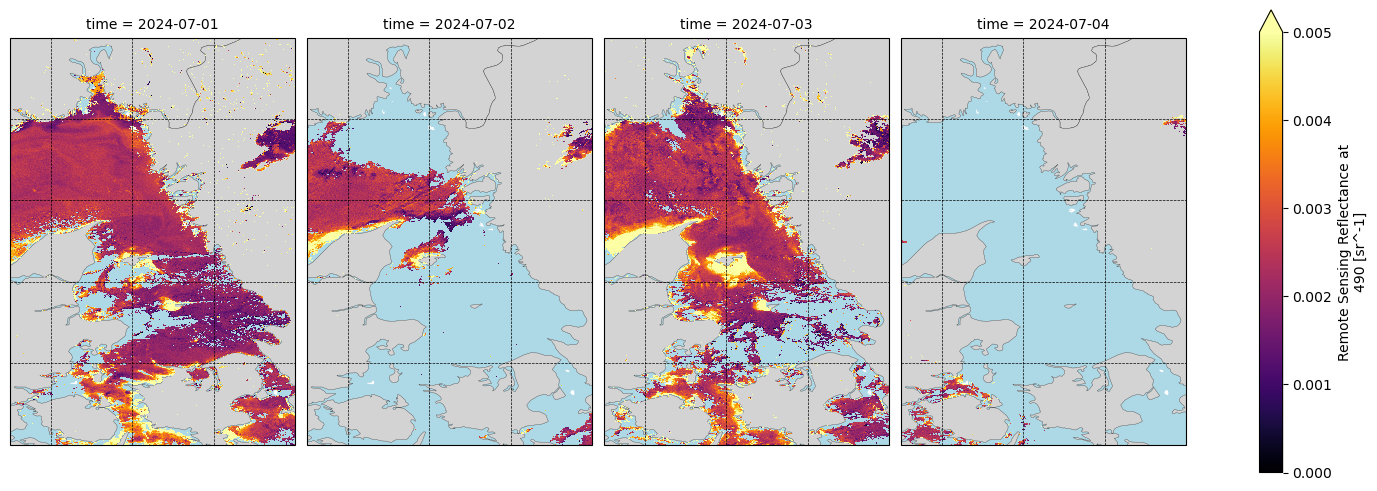

In [25]:
fig = ds.RRS490.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=0.005,
    cmap = 'inferno',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
Now we will visualize the first 4 days of our RRS708_75 data. You will see that we have lots of gaps - this is due to cloud cover interfering with the OLCI sensor data acquisition. We will address this problem in the following code.
</div>

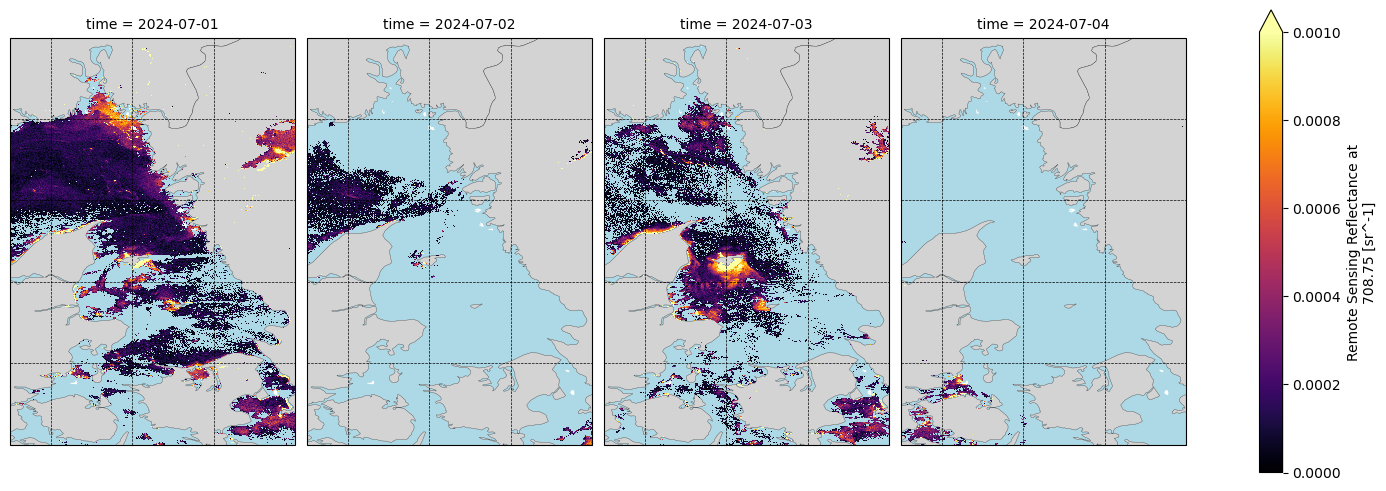

In [26]:
fig = ds.RRS708_75.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=0.001,
    cmap = 'inferno',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We now apply a forward filling technique to fill in data gaps caused by cloud cover. This takes the last valid pixel value and carries that data through in the time dimension. We limit the forward filling to 7 days to make sure that we are not looking at data outdated by more that a week. We then plot the first four days of data again to see the effect of the forward fill in comparison with the above maps which visualize the raw data. We now have a more complete dataset for RRS409 and RRS708_75 over our entire time series.
</div>

In [27]:
ds_fill = ds.ffill(dim='time', limit=7)

<div class="alert alert-block alert-warning"> 
RRS409 forward filling
</div>

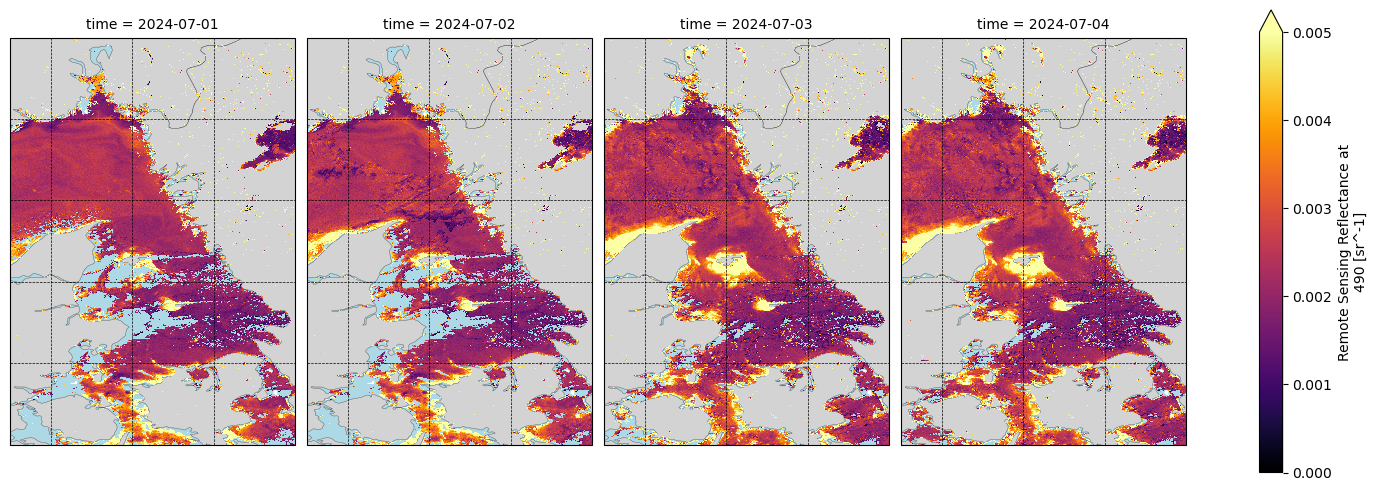

In [28]:
fig = ds_fill.RRS490.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()), 
    vmin=0, 
    vmax=0.005,
    cmap = 'inferno',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
RRS708_75 forward filling
</div>

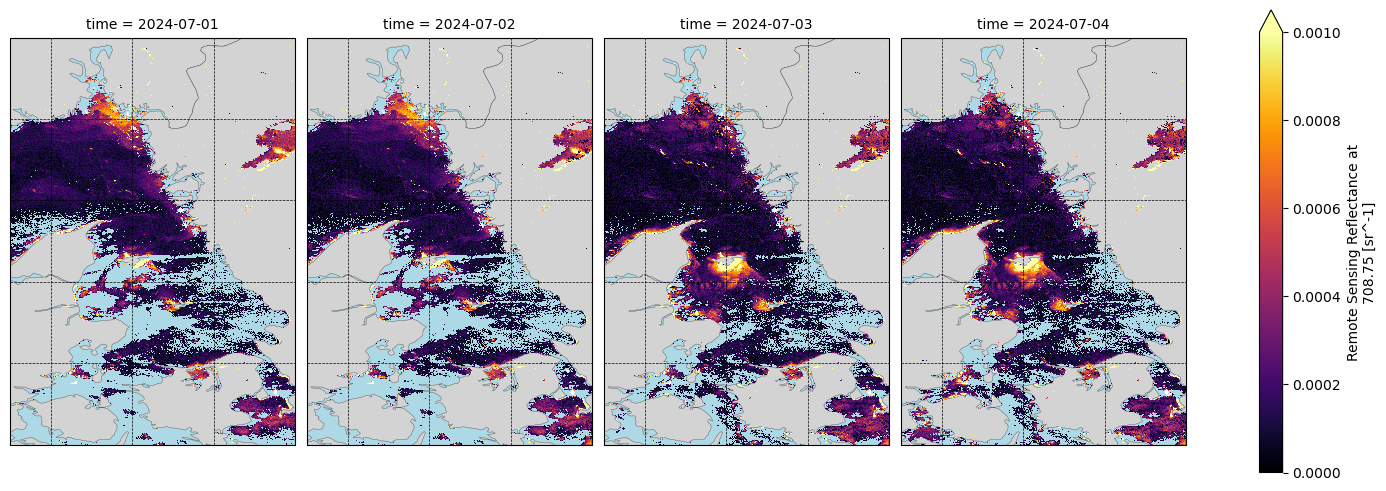

In [29]:
fig = ds_fill.RRS708_75.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
#    col_wrap=3, 
    vmin=0, 
    vmax=0.001,
    cmap = 'inferno',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We can see that the image is filled in progressively with data from previous days. For example, in the forward filled dataset May 4th has values for almost our entire area of interest, whereas in the original dataset there were many gaps in the May 4th image.
</div>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>2. Calculating the Secchi Depth
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
Our next step is to use the RRS490 and RRS708_75 to calculate the Secchi Depth (SD) with the algorithm below with the datasets ratio R(490)/R(709). The algorithm comes from the artikel of Alikas, K., & Kratzer, S. (2017), as follows;
    
$SD = (R(490))/R(709))**0.697*2.1370$

To remove noise and other distortions in the data (unreasonable values), we set a maximum limit of 20 meters for the highest value. All values above 20 are assigned the value 20 to make the data more realistic.
We also calculate the average value for each pixel (ds_mean) over the specified time period. This averaged dataset will be used further in the analysis.

You can see in the following code that we create a new variable (SD) to store the results of this equation, thus retaining our original data in the dataset. We take a look at the resulting dataset to make sure that SD has indeed been added.

Note: The algorithm is applied to the Baltic Sea, so a certain overestimation of the values may occur. The algorithm also tends to overestimate the secchi deoth during the summer. "It is hypothesized that elevated levels of cyanobacteria may be responsible, as they influence the applied band ratio. Cyanobacteria scatter light similarly to inorganic suspended matter, which likely constrained the algorithm’s ability to capture water transparency through the blue-red wavelength relationship"
</div>

In [30]:
# forward-fill the dataset and calculate the secchi depth (SD)
ds_fill = ds_fill.assign(SD=((ds_fill['RRS490']/ds_fill['RRS708_75'])**0.697)*2.137)

# Limits all values in the SD variable to maximum of 20, values >20 are replaced with 30.
ds_fill['SD']=ds_fill['SD'].clip(max=20)

# remote Time dimension and average for each pixel across time series
ds_mean = ds_fill.mean(dim='time', skipna=True)

# plot the mean data
ds_fill

<xarray.Dataset> Size: 454MB
Dimensions:    (latitude: 1856, longitude: 658, time: 31)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 248B 2024-07-01 2024-07-02 ... 2024-07-31
Data variables:
    RRS490     (time, latitude, longitude) float32 151MB nan nan nan ... nan nan
    RRS708_75  (time, latitude, longitude) float32 151MB nan nan nan ... nan nan
    SD         (time, latitude, longitude) float32 151MB nan nan nan ... nan nan
Attributes: (12/39)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2024-01-21
    stop_date:               2024-01-21
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-reflectance_my_l3-olci-300m...
    westernmost_longitude:   9.25

In [31]:
DS_num =ds_fill['SD'].to_numpy()

In [32]:
max_value =np.nanmax(DS_num)
min_value =np.nanmin (DS_num)
mean_value =np.nanmean(DS_num)
median_value=np.nanmedian(DS_num)
std_value =np. nanstd(DS_num)
print(f"Mean: {mean_value}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standardization: {std_value}")

Mean: 15.248199462890625
Max: 20.0
Min: 0.006392315961420536
Mean: 15.248199462890625
Median: 16.465547561645508
Standardization: 5.002721309661865


<div class="alert alert-block alert-warning"> 
We now visualize the Secchi Depth for the first four days of our dataset on a scale of 0-30 meters.
</div>

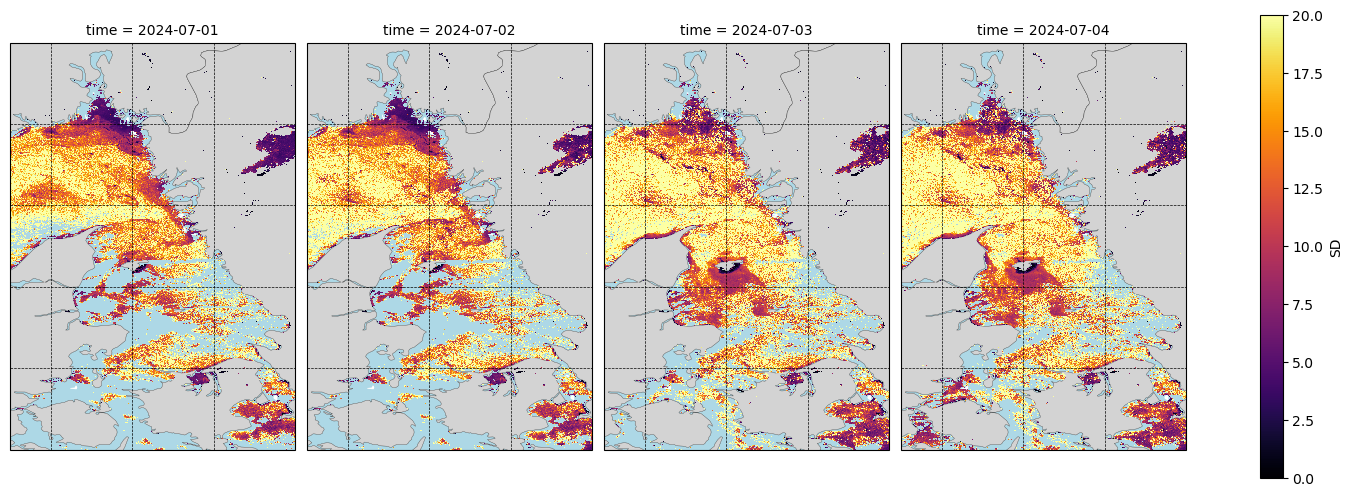

In [33]:
fig = ds_fill.SD.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
#    col_wrap=3, 
    vmin=0, 
    vmax=20,
    cmap = 'inferno',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-info" role="alert">

## <a id='section1'></a>3. Read in the coast water areas (KVF)
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
We now load and clip the coastal water areas (KVF) to match our study area..
</div>

<Axes: >

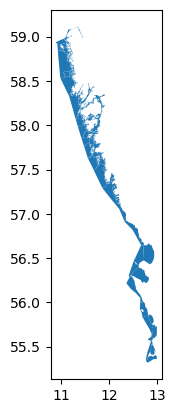

In [34]:
# read in kustvattenförekomster and clip to the study area

kvf = os.path.join('external_data', 'VM', 'vm.Kustvatten_Vattenforekomster_2016_1.shp')
kvf = gpd.read_file(kvf)
kvf = kvf.to_crs(4326)

c =  {'NW': [9.5, 60],
      'NE': [13, 60],
      'SW': [9.5, 55],
      'SE': [13, 55]}

bb = Polygon([c['NW'], c['NE'], c['SE'], c['SW']])

kvf_clipped = kvf.clip(bb)
kvf_clipped.plot()

<div class="alert alert-block alert-warning"> 
Now we check out the geodataframe info.
</div>

In [35]:
kvf_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121 entries, 574 to 499
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    121 non-null    int64   
 1   UUID        121 non-null    object  
 2   MS_CD       121 non-null    object  
 3   EU_CD       121 non-null    object  
 4   VISS_MS_CD  121 non-null    object  
 5   NAMN        121 non-null    object  
 6   TYP_NFS06   121 non-null    int64   
 7   TYPOMRKUST  121 non-null    object  
 8   CATEGORY    121 non-null    object  
 9   WB          121 non-null    object  
 10  District    121 non-null    object  
 11  COMP_AUTH   121 non-null    object  
 12  Country     121 non-null    object  
 13  Version     121 non-null    object  
 14  URL_VISS    121 non-null    object  
 15  ObjVer      121 non-null    object  
 16  GVatten     121 non-null    object  
 17  UTL_EU_CD   4 non-null      object  
 18  UTL_MS_CD   4 non-null      object  
 19  SHA

<div class="alert alert-block alert-warning"> 
Now we dissolve kvf by 'TYPOMRKUST' to find all coastal water areas that we are intrested in. 
</div>

In [36]:
kvf_dissolved = kvf_clipped.dissolve(by='TYPOMRKUST')
kvf_dissolved = kvf_dissolved.reset_index()

for row in kvf_dissolved.itertuples():
    print(f'Index {row.Index}: TYPOMRKUST <{row.TYPOMRKUST}>')

Index 0: TYPOMRKUST <1n>
Index 1: TYPOMRKUST <1s>
Index 2: TYPOMRKUST <2>
Index 3: TYPOMRKUST <25>
Index 4: TYPOMRKUST <3>
Index 5: TYPOMRKUST <4>
Index 6: TYPOMRKUST <5>
Index 7: TYPOMRKUST <6>
Index 8: TYPOMRKUST <7>


<div class="alert alert-block alert-warning"> 
Now we clip the mean value dataset after the costal water areas (KVF) and store each area in ds_mclipped.
</div>

In [37]:
ds_mean = ds_mean.rio.write_crs(4326)
ds_mclipped=[]
for index, row in kvf_dissolved.iterrows():
    aoi = ds_mean.rio.clip([row['geometry']], all_touched=True)
    ds_mclipped.append(aoi)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>4. Secchi Depth within coastal water areas (KVF)
[Back to top](#TOC_TOP)

</div>

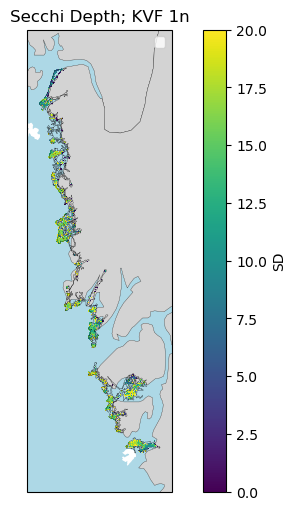

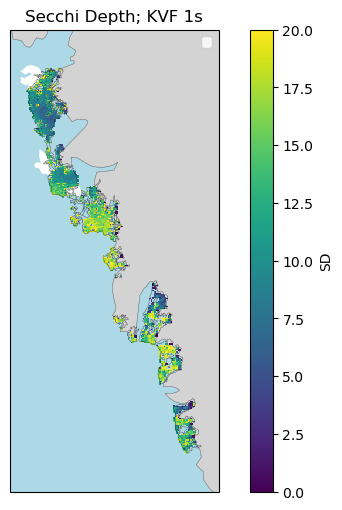

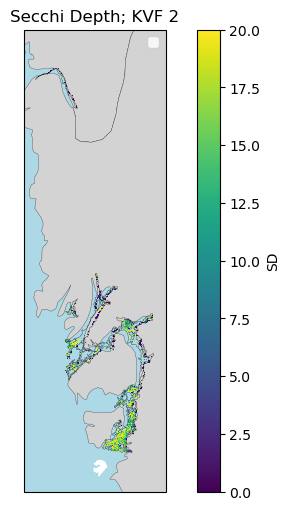

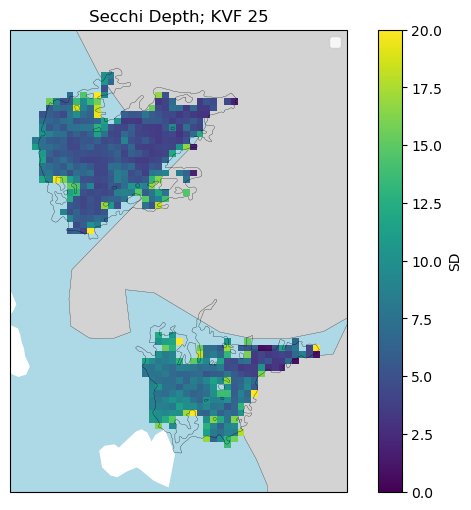

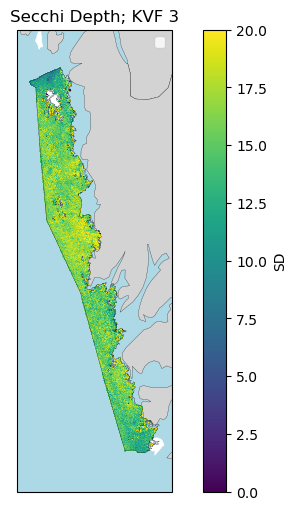

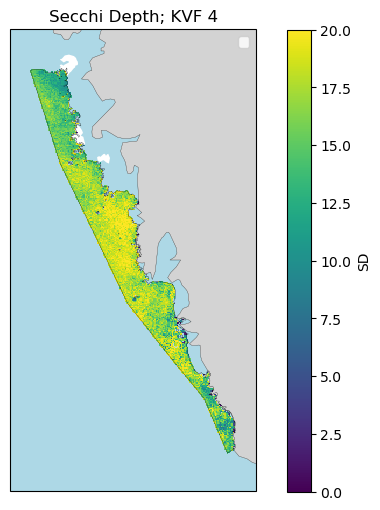

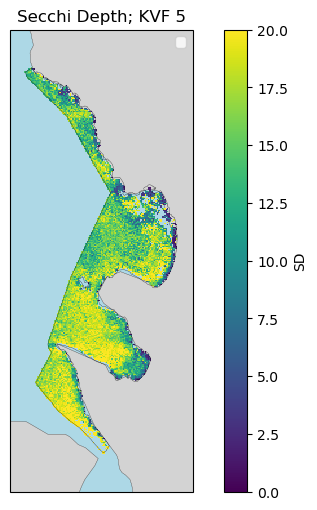

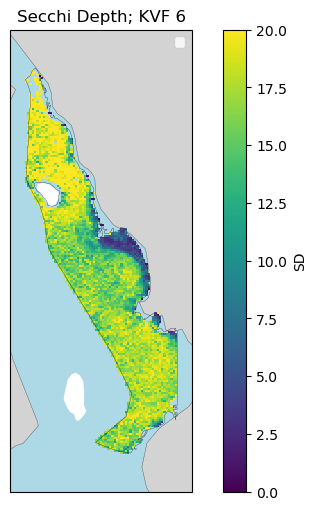

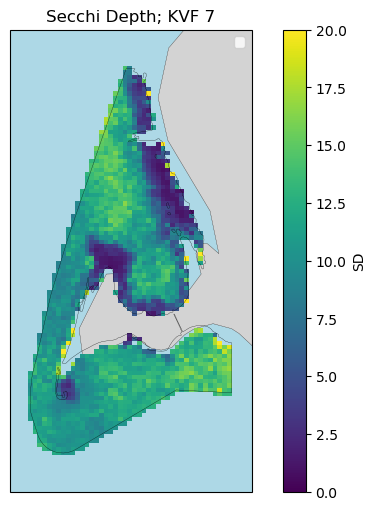

In [41]:
# Maps e
int_to_class = list()
for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]
    fig, ax = plt.subplots(1,1, figsize=(8, 6),subplot_kw=dict(projection=ccrs.PlateCarree()))
    data['SD'].plot(ax=ax,vmin=0, vmax=20, zorder=2)

    kvf_dissolved.iloc[[ind]].boundary.plot(ax=ax, edgecolor="black",lw=0.2)

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"

    legend_patches = [mpatches.Patch(color=class_colors[label], label=label)
                  for label in int_to_class
                 ]
    ax.legend(handles=legend_patches, loc='upper right', frameon=True, facecolor='white')
    
    ax.add_feature(land, zorder=1)    
    ax.add_feature(ocean, zorder=0)    
    bounds=kvf_dissolved.iloc[ind].geometry.bounds
    minx, miny, maxx, maxy = bounds
    pad_x = (maxx - minx) * 0.1
    pad_y = (maxy - miny) * 0.1
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.set_title(f"Secchi Depth; KVF {area_name}", fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

<div class="alert alert-info" role="alert">

## <a id='section1'></a>5. EK Classification of Secchi Depth in coastal water areas (KVF)
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
This step processes secchi depth measurements from the coastal water areas to classify their ecological status. It utilizes thresholds from the HVMFS 2019:25 guidelines, specifically the reference values and ecological quality ratios (EK), to determine the status classes: High, Good, Moderate, Unsatisfactory, and Poor. The result is a series of maps, one per coastal water area, illustrating the EK classification. For each area, a summary table is also provided, showing the pixel count and percentage distrubution for each class within the area.
</div>

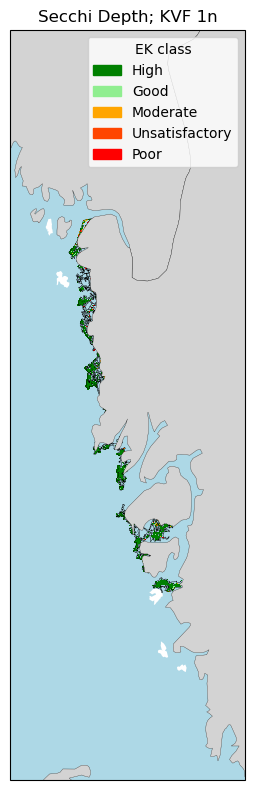

,Class,Pixel count,(%)
,Moderate,70,3.4
,High,1718,84.3
,Unsatisfactory,29,1.4
,Good,72,3.5
,Poor,150,7.4


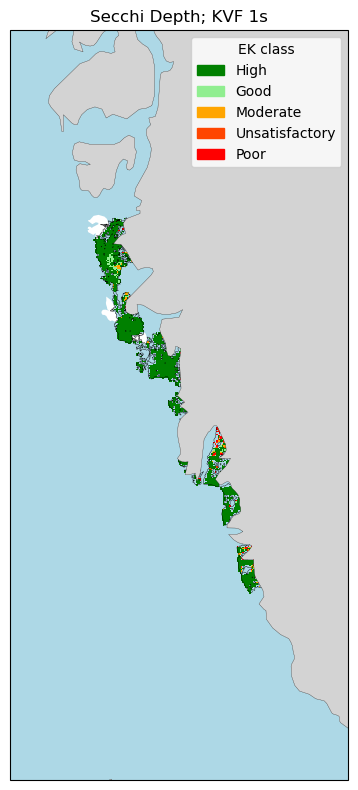

,Class,Pixel count,(%)
,High,2450,87.5
,Good,109,3.9
,Moderate,79,2.8
,Poor,128,4.6
,Unsatisfactory,34,1.2


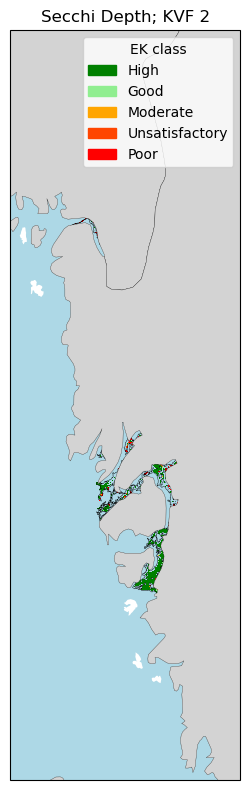

,Class,Pixel count,(%)
,High,1090,72.5
,Good,35,2.3
,Unsatisfactory,32,2.1
,Poor,318,21.1
,Moderate,29,1.9


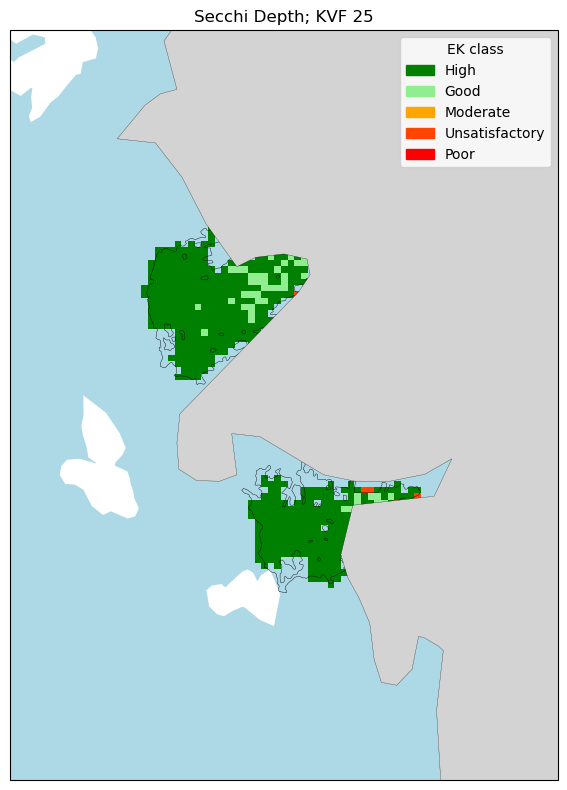

,Class,Pixel count,(%)
,High,521,89.7
,Good,50,8.6
,Moderate,3,0.5
,Unsatisfactory,7,1.2


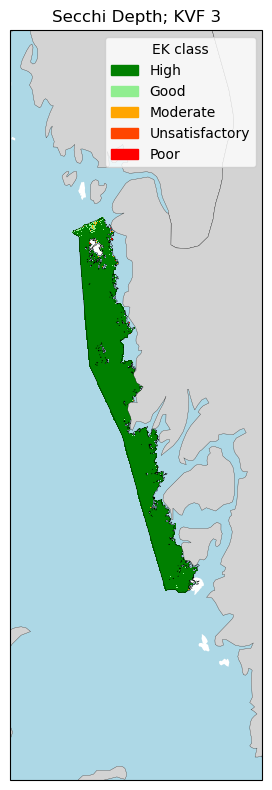

,Class,Pixel count,(%)
,High,13302,98.6
,Moderate,29,0.2
,Good,141,1.0
,Poor,12,0.1
,Unsatisfactory,2,0.0


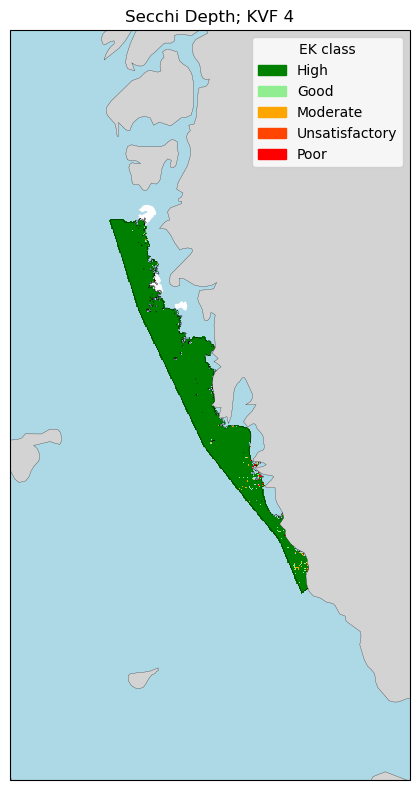

,Class,Pixel count,(%)
,High,9210,98.1
,Good,74,0.8
,Unsatisfactory,11,0.1
,Poor,46,0.5
,Moderate,44,0.5


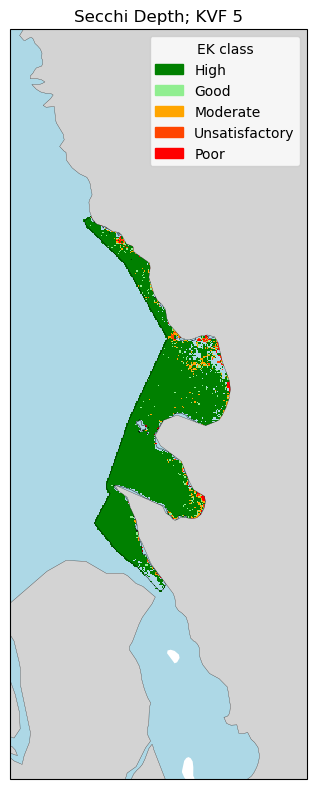

,Class,Pixel count,(%)
,High,9825,90.8
,Good,289,2.7
,Poor,220,2.0
,Moderate,356,3.3
,Unsatisfactory,133,1.2


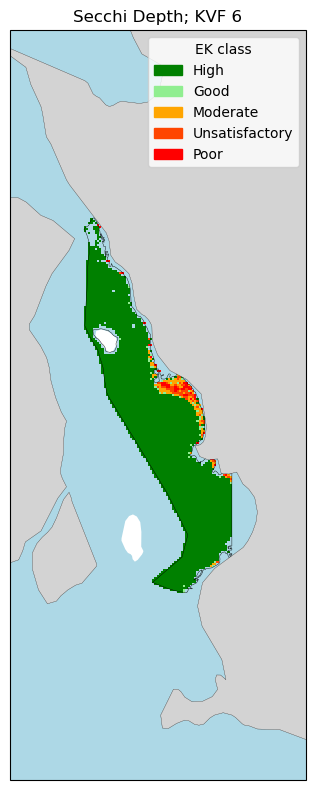

,Class,Pixel count,(%)
,High,3969,93.8
,Good,45,1.1
,Moderate,108,2.6
,Unsatisfactory,63,1.5
,Poor,48,1.1


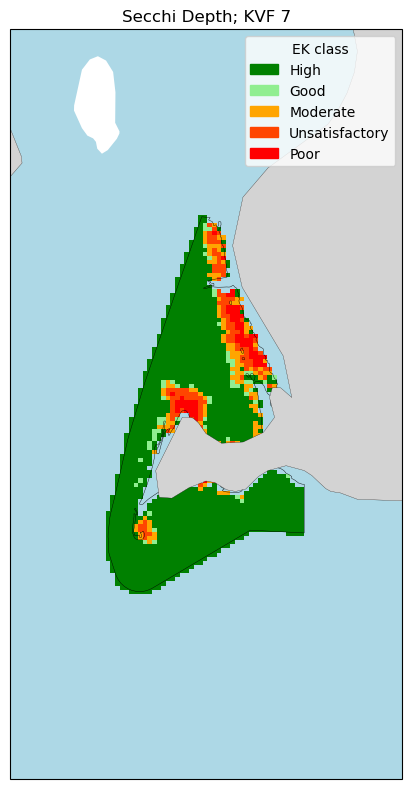

,Class,Pixel count,(%)
,High,1456,77.6
,Good,61,3.2
,Moderate,158,8.4
,Unsatisfactory,135,7.2
,Poor,67,3.6


In [39]:
# EK-table. A list containing reference values (Rv) and threshold ratios (HG, GM, MO, OD) for different water body types (Typ), as specified in HVMFS 2019:25.
ek_table = [
    {"Typ": "1n", "Rv": 10.5, "HG": 0.81, "GM": 0.67, "MO": 0.48, "OD": 0.29},
    {"Typ": "1s", "Rv": 8,    "HG": 0.81, "GM": 0.69, "MO": 0.50, "OD": 0.38},
    {"Typ": "2", "Rv": 8,     "HG": 0.81, "GM": 0.63, "MO": 0.44, "OD": 0.31},
    {"Typ": "3",  "Rv": 12,   "HG": 0.83, "GM": 0.67, "MO": 0.42, "OD": 0.29},
    {"Typ": "25", "Rv": 4.5,  "HG": 0.89, "GM": 0.67, "MO": 0.45, "OD": 0.11},
    {"Typ": "4",  "Rv": 10.5, "HG": 0.9,  "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "5",  "Rv": 10.5, "HG": 0.90, "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "6",  "Rv": 10.0, "HG": 0.90, "GM": 0.75, "MO": 0.45, "OD": 0.30},
    {"Typ": "7",  "Rv": 10.0, "HG": 0.83, "GM": 0.70, "MO": 0.40, "OD": 0.20},
]

# Dictionary mapping each water body type to its corresponding thresholds for quick access during classification
ek_dict = {row["Typ"]: row for row in ek_table}

# Dictionary assigning specific colors to each ecological status class for visualization purposes
class_colors = {
    "High": "green",
    "Good": "lightgreen",
    "Moderate": "orange",
    "Unsatisfactory": "orangered",
    "Poor": "red"
}

# Maps each status class to an integer, facilitating numerical classification
class_to_int = {k: i for i, k in enumerate(class_colors.keys())}
int_to_class = list(class_colors.keys())

# create dataArray that will hold the combined classification results for all processed water bodies
combined_array = None

# Process the data from each coastal water and calculates the EK ratio by dividing the Secchi Depth by the reference value, and assigns an ecological status class based on the thresholds. 
# The results are stored in the DataArray combined_array.
for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]

    try:
        typ = str(kvf_dissolved.iloc[ind]['TYPOMRKUST']).strip()
        thresholds = ek_dict[typ]
        ref = thresholds["Rv"]
    except KeyError:
        continue

    sd_values = data['SD']
    ek_values = sd_values/ref 
    valid_mask = ~np.isnan(sd_values)

    classification_array = np.full_like(sd_values, np.nan)
    mask = valid_mask.copy()
    classification_array[(ek_values > thresholds["HG"]) & mask] = class_to_int["High"]
    mask &= ~(ek_values > thresholds["HG"])
    classification_array[(ek_values > thresholds["GM"]) & mask] = class_to_int["Good"]
    mask &= ~(ek_values > thresholds["GM"])
    classification_array[(ek_values > thresholds["MO"]) & mask] = class_to_int["Moderate"]
    mask &= ~(ek_values > thresholds["MO"])
    classification_array[(ek_values > thresholds["OD"]) & mask] = class_to_int["Unsatisfactory"]
    mask &= ~(ek_values > thresholds["OD"])
    classification_array[mask] = class_to_int["Poor"]

    class_da = xr.DataArray(
        classification_array,
        coords=data['SD'].coords,
        dims=data['SD'].dims
    )

    # Combine all classifications
    if combined_array is None:
        combined_array = class_da
    else:
        combined_array = combined_array.combine_first(class_da)

    #Set Up Colormap and Normalization and ensuring that missing data is transparent
    cmap = ListedColormap([class_colors[c] for c in int_to_class])
    cmap.set_bad((0,0,0,0))
    norm = plt.Normalize(vmin=0, vmax=len(class_to_int) - 1)

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"
        
    #Create the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 8),subplot_kw=dict(projection=ccrs.PlateCarree()))
    class_da.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    kvf_dissolved.iloc[[ind]].plot(ax=ax, edgecolor='black', facecolor='none',lw=0.3)

    #Add Legend and Additional Features
    legend_patches = [mpatches.Patch(color=class_colors[label], label=label)
                  for label in int_to_class
                 ]
    ax.legend(handles=legend_patches, loc='upper right', title="EK class", frameon=True, facecolor='white')
    bounds=kvf_dissolved.iloc[ind].geometry.bounds
    minx, miny, maxx, maxy = bounds
    pad_x = (maxx - minx) * 0.5
    pad_y = (maxy - miny) * 0.5
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.add_feature(land, zorder=1)    
    ax.add_feature(ocean, zorder=0) 
    ax.set_title(f"Secchi Depth; KVF {area_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    

    # Flatten the classification array and exclude NaN values
    flat_array = classification_array[~np.isnan(classification_array)].astype(int).ravel()
    total_pixels = len(flat_array)
    plt.show()
    
    # Count number of pixels per class
    counts = Counter(flat_array)
    
    # Create list of rows with class name, pixel count, and percentage
    pixel_stats = []
    for class_index, count in counts.items():
        class_name = int_to_class[class_index]
        percentage = 100 * count / total_pixels
        pixel_stats.append([class_name, count, round(percentage, 1)])
    
    # Create and display the statistic table
    pixel_df = pd.DataFrame(pixel_stats, columns=["Class", "Pixel count", "(%)"])
    pixel_df.index = [''] * len(pixel_df)
    display(pixel_df)

<div class="alert alert-block alert-warning"> 
This step visualizes the combined classification of all coastal water areas in a single map. It uses the results from the previous classification step, which assigned each grid cell an ecological status class (High, Good, Moderate, Unsatisfactory, or Poor) based on thresholds from the HVMFS 2019:25 guidelines. The output is one comprehensive map displaying the EK classification for all areas.
</div>


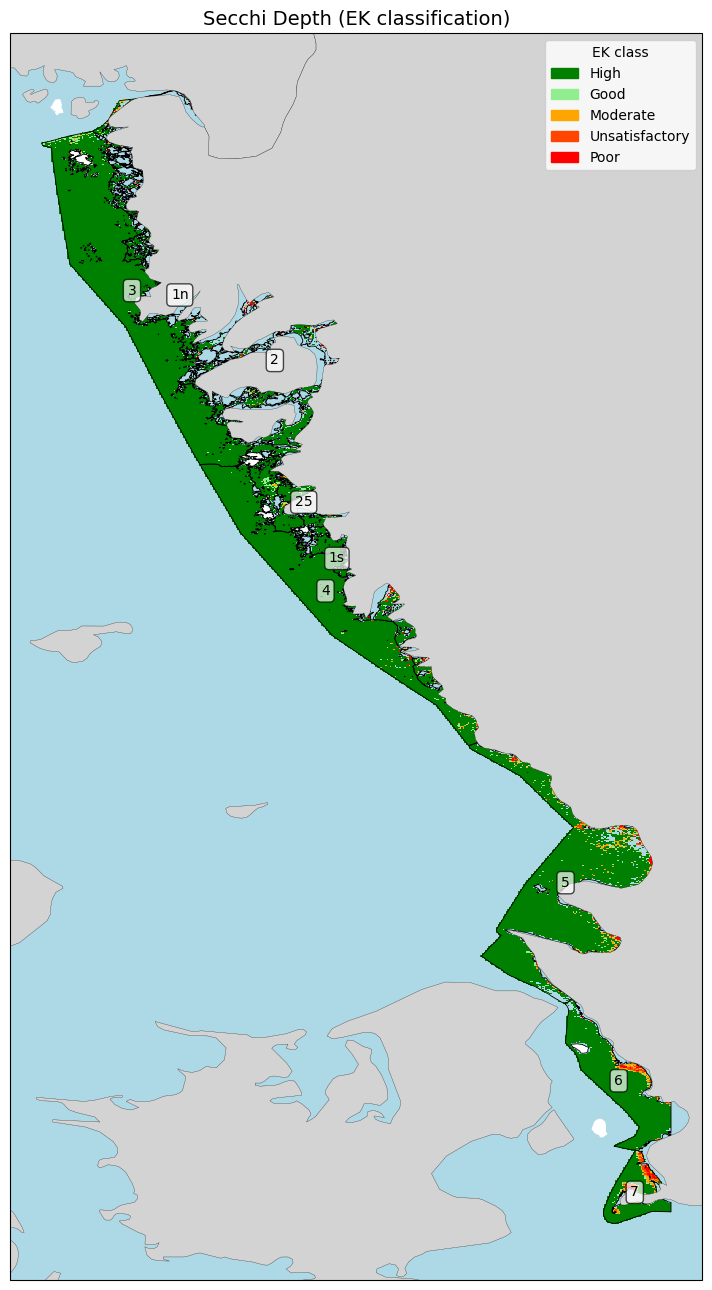

In [40]:
# Color map and normalization for the classification
cmap = ListedColormap([class_colors[c] for c in int_to_class])
cmap.set_bad((0, 0, 0, 0))  # Make missing data transparent
norm = plt.Normalize(vmin=0, vmax=len(int_to_class) - 1)

# Create plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 13), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the full classified data for all areas
img = combined_array.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Add legend for EK classes
legend_patches = [mpatches.Patch(color=class_colors[label], label=label) for label in int_to_class]
ax.legend(handles=legend_patches, loc='upper right', title="EK class", frameon=True, facecolor='white')

# Outline the water bodies
kvf_dissolved.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.6)

# Add labels to each area
for idx, row in kvf_dissolved.iterrows():
    centroid = row.geometry.centroid
    label = str(row['TYPOMRKUST'])
    ax.text(
        centroid.x, centroid.y, label,
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.7)
    )

# Set extent and map details
minx, miny, maxx, maxy = kvf_dissolved.total_bounds
pad_x = (maxx - minx) * 0.05
pad_y = (maxy - miny) * 0.05
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)
ax.add_feature(land, zorder=1)
ax.add_feature(ocean, zorder=0)
ax.set_title("Secchi Depth (EK classification)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()